In [44]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [11]:
flist = glob('../data/bestfits/*')

In [26]:
field = [os.path.basename(U).split('_')[0] for U in flist]
galaxy = np.array([os.path.basename(U).split('_')[1] for U in flist]).astype(np.int)

In [33]:
PWV , BWV, RWV =[[],[],[]]
PIE , BIE, RIE =[[],[],[]]
PE , BE, RE =[[],[],[]]

for i in range(len(flist)):
    g1,g2,bfm,bfa,bft,bfz,bfd = np.load(flist[i])

    BFM, BFA, BFT, BFZ, BFD = np.array([bfm,bfa,bft,bfz,bfd]).astype(float)

    GS = Gen_spec(field[i],galaxy[i], BFZ,
                g102_lims=[7000, 12000], g141_lims=[10000, 18000], mdl_err = False, instr_err = False,phot_errterm = 0.3, decontam=True)
    GS.Sim_all(BFM/0.019, BFA, BFT, BFZ, BFD)

    PWV.extend(GS.Pwv)
    PIE.extend(((GS.Pflx - GS.Pmfl) / GS.Pflx)**2)
    PE.extend(((GS.Perr)/GS.Pflx)**2)

    if GS.g102: 
        BWV.extend(GS.Bwv)
        BIE.extend(((GS.Bfl - GS.Bmfl) / GS.Bfl)**2)
        BE.extend(((GS.Ber)/GS.Bfl)**2)

    if GS.g141: 
        RWV.extend(GS.Rwv)
        RIE.extend(((GS.Rfl - GS.Rmfl) / GS.Rfl)**2)
        RE.extend(((GS.Rer)/GS.Rfl)**2)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3452: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3457: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3458: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_pr

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g141
missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3452: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3457: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3458: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.iv

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3452: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3457: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3458: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_pr

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3452: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3457: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3458: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_pro

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3452: RuntimeWarning: invalid value encountered in sqrt
  resid = np.abs(self.scif - self.flat_flam)*np.sqrt(self.ivarf)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3457: RuntimeWarning: invalid value encountered in sqrt
  contam_mask = ((self.contam*np.sqrt(self.ivar) > contam_sn_mask[0]) &
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3458: RuntimeWarning: invalid value encountered in sqrt
  (self.model*np.sqrt(self.ivar) < contam_sn_mask[1]))
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: divide by zero encountered in true_divide
  self.optimal_pr

cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


missing g102


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


cleaned


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3423: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.8.0_4_g1153432-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:548: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


In [34]:
IDP = np.argsort(PWV)
IDB = np.argsort(BWV)
IDR = np.argsort(RWV)

In [35]:
orderedpwv = list(set(PWV))

In [36]:
intrerr = []
nerr = []

for i in orderedpwv:
    ie = []
    ne = []
    for ii in IDP:
        if i == PWV[ii]:
            ie.append(PIE[ii])
            ne.append(PE[ii])
    intrerr.append(ie)
    nerr.append(ne)

In [37]:
mie = [np.median(U) for U in intrerr] 
me = [np.median(U) for U in nerr] 

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in sqrt
  


([<matplotlib.axis.XTick at 0x1a7bfb62b0>,
 <a list of 6 Text xticklabel objects>)

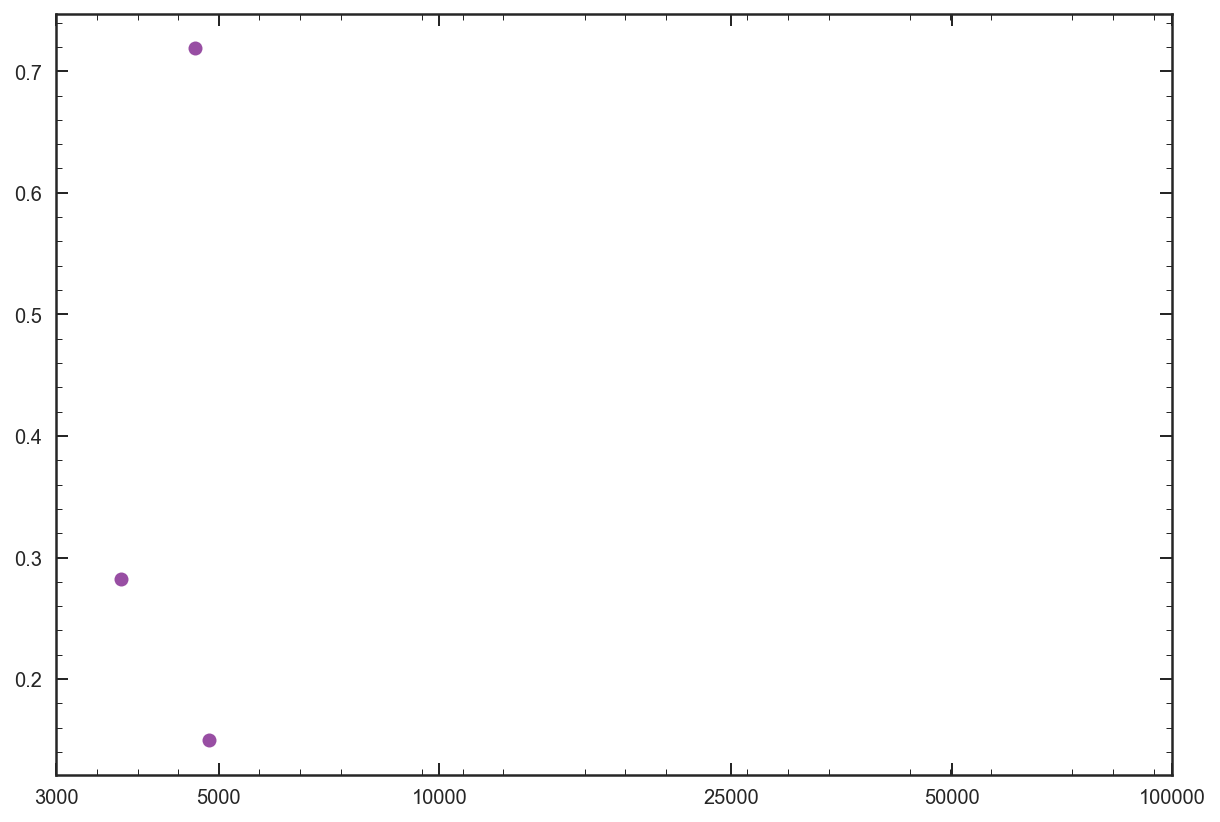

In [38]:
plt.figure(figsize=[10,7])
plt.plot(np.log10(orderedpwv), np.sqrt(np.array(mie) - np.array(me)), 'o', color='#984ea3')
plt.xticks(np.log10([3000,5000,10000,25000,50000,100000]),[3000,5000,10000,25000,50000,100000])

In [39]:
def Run_bin_stat(wv,tmp,bin_size):
    wv = wv[tmp**2 > 0]
    tmp = tmp[tmp**2 > 0]
    
    
    wv_med = [] ; wv_mean = [] ; binned_data = []

    low_lim = min(wv)
    while low_lim <= max(wv):
        IDX = [U for U in range(len(wv)) if low_lim <= wv[U] < low_lim + bin_size]
        wv_med.append(np.median(wv[IDX]))
        wv_mean.append(np.median(low_lim + bin_size / 2))
        binned_data.append(np.median(tmp[IDX]))
        low_lim += bin_size
    return np.array(wv_med), np.array(wv_mean), np.array(binned_data)

In [40]:
BWV_med, BWV_mean, BIE_bin = Run_bin_stat(np.array(BWV)[IDB], np.array(BIE)[IDB],100)
BWV_med, BWV_mean, BE_bin = Run_bin_stat(np.array(BWV)[IDB], np.array(BE)[IDB],100)

RWV_med, RWV_mean, RIE_bin = Run_bin_stat(np.array(RWV)[IDR], np.array(RIE)[IDR],100)
RWV_med, RWV_mean, RE_bin = Run_bin_stat(np.array(RWV)[IDR], np.array(RE)[IDR],100)

In [41]:
intr_err_b = BIE_bin - BE_bin
intr_err_r = RIE_bin - RE_bin

intr_err_b[intr_err_b < 0] = 0
intr_err_r[intr_err_r < 0] = 0

In [42]:
rwv = np.arange(min(RWV), max(RWV) + 500, 500)
rief = [0.18, 0.09, 0.01,0.01, 0.01, 0.01, 0.01,
        0.01, 0.01, 0.01, 0.01, 0.01, 0.03, 0.15, 0.18]

rwvs = np.arange(min(RWV), max(RWV) + 10, 5)
irief = interp1d(rwv,rief)(rwvs)

TypeError: Smooth() takes 2 positional arguments but 3 were given

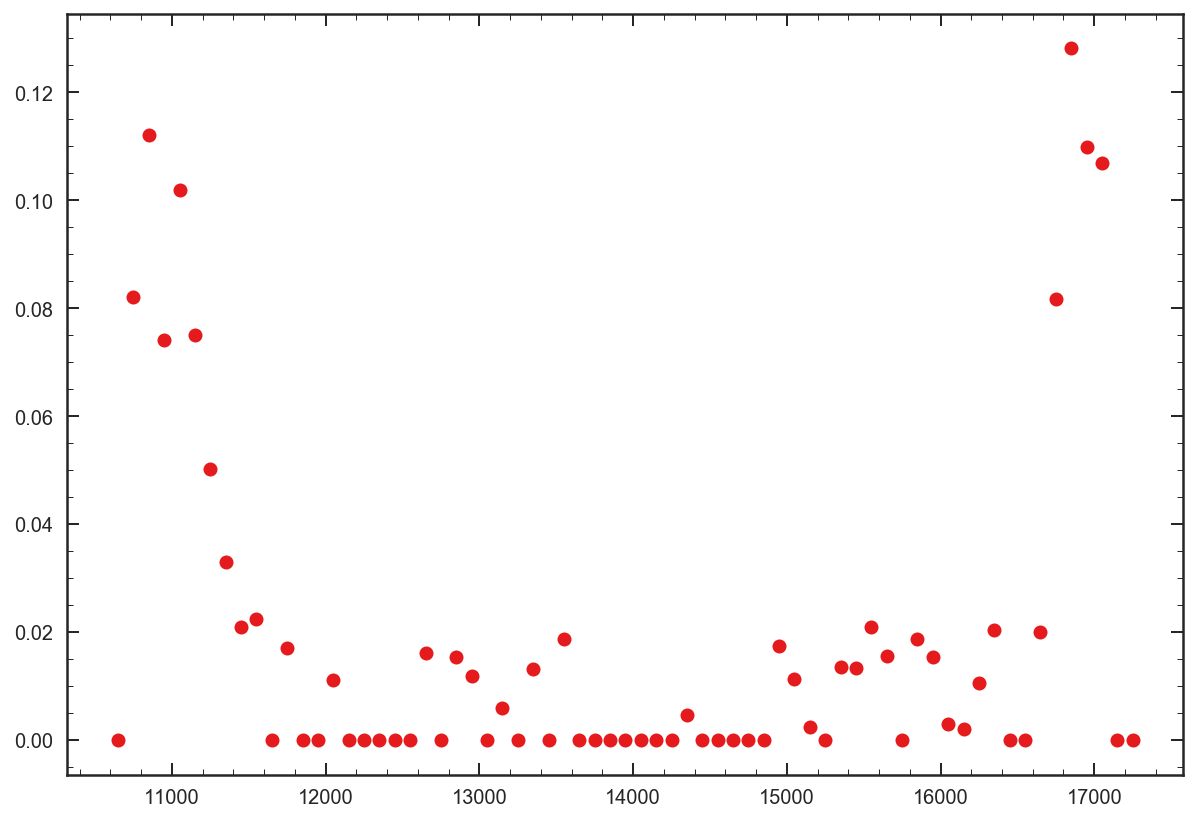

In [43]:
plt.figure(figsize=[10,7])

# plt.plot(BWV_mean, np.sqrt(intr_err_b), 'o', color='#377eb8')

plt.plot(RWV_mean, np.sqrt(intr_err_r), 'o', color='#e41a1c')
# plt.plot(rwv,rief, 'k')
plt.plot(rwvs, Smooth(irief,rwvs,100), 'c', linewidth = 5, alpha = 0.3)

In [6]:
def Sig_int(er):
    sig = np.zeros(len(er)-1)
    
    for i in range(len(er)-1):
        sig[i] = np.sqrt(er[i]**2 + er[i+1]**2 )
    
    return np.sum((1/2)*sig)

def SN(w, f, e, wmin, wmax):
    
    IDx = [U for U in range(len(w)) if wmin < w[U] < wmax]
    
    return np.trapz(f[IDx])/ Sig_int(e[IDx])

def SN_full(Bw, Bf, Be, Rw, Rf, Re, Bmin, Bmax, Rmin, Rmax):
    
    IDb = [U for U in range(len(Bw)) if Bmin < Bw[U] < Bmax]
    IDr = [U for U in range(len(Rw)) if Rmin < Rw[U] < Rmax]
    
    return np.trapz(np.append(Bf[IDb],Rf[IDr]))/ Sig_int(np.append(Be[IDb],Re[IDr]))

In [6]:
# Bwv = [] ; Bres = [] ; Bnerr = []
# Rwv = [] ; Rres = [] ; Rnerr = []
# Pwv = [] ; Pres = [] ; Pnerr = []
wv = [] ; res = [] ; nerr = []

for i in galDB.index:
    sp = Gen_spec(galDB.field[i], galDB.ids[i], galDB.z_grism[i], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[i]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[i]))[0],g102_lims=[7700, 11500], g141_lims=[10800, 16600])   
    
    if SN_full(sp.Bwv, sp.Bflx, sp.Berr,sp.Rwv, sp.Rflx, sp.Rerr, 8500, 11300,11100, 16000) > 6:
        
        if bftau[gids == galDB.ids[i]][0] == 0:
            BFTAU  = int(0)
        else:
            BFTAU = bftau[gids == galDB.ids[i]][0]

        sp.Sim_all(bfZ[gids == galDB.ids[i]][0], bft[gids == galDB.ids[i]][0],BFTAU,
                            bfz[gids == galDB.ids[i]][0], bfd[gids == galDB.ids[i]][0])
        wv.extend(sp.Bwv_rf)
        res.extend((sp.Bflx - sp.Bmfl) / sp.Bflx)
        nerr.extend(sp.Berr / sp.Bflx)    

        wv.extend(sp.Rwv_rf)
        res.extend((sp.Rflx - sp.Rmfl) / sp.Rflx)
        nerr.extend(sp.Rerr / sp.Rflx)    

        wv.extend(sp.Pwv_rf)
        res.extend((sp.Pflx - sp.Pmfl) / sp.Pflx)
        nerr.extend(sp.Perr / sp.Pflx)    

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.e

In [39]:
IDBW =np.array(Bwv).argsort()

B_wave = np.array(Bwv)[IDBW]
B_tmp_err = np.sqrt(np.array(Bres)**2 - np.array(Bnerr)**2)[IDBW]

B_wave_filt = B_wave[B_tmp_err**2 > 0]
B_tmp_err = B_tmp_err[B_tmp_err**2 > 0]

B_wave_filt = B_wave_filt[B_tmp_err < 100]
B_tmp_err = B_tmp_err[B_tmp_err < 100]

IDRW =np.array(Rwv).argsort()

R_wave = np.array(Rwv)[IDRW]
R_tmp_err = np.sqrt(np.array(Rres)**2 - np.array(Rnerr)**2)[IDRW]

R_wave_filt = R_wave[R_tmp_err**2 > 0]
R_tmp_err = R_tmp_err[R_tmp_err**2 > 0]

R_wave_filt = R_wave_filt[R_tmp_err < 100]
R_tmp_err = R_tmp_err[R_tmp_err < 100]

IDPW =np.array(Pwv).argsort()

P_wave = np.array(Pwv)[IDPW]
P_tmp_err = np.sqrt(np.array(Pres)**2 - np.array(Pnerr)**2)[IDPW]

P_wave_filt = P_wave[P_tmp_err**2 > 0]
P_tmp_err = P_tmp_err[P_tmp_err**2 > 0]

P_wave_filt = P_wave_filt[P_tmp_err < 100]
P_tmp_err = P_tmp_err[P_tmp_err < 100]

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in sqrt
  from ipykernel import kernelapp as app
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in greater
/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in greater
/Users/vestr

In [3]:
def Smooth(f,x,bw):
    ksmooth = importr('KernSmooth')

    ### select bandwidth
    H = ksmooth.dpik(x)
    
    if bw == 'none':
        bw = H
    
    fx = ksmooth.locpoly(x,f,bandwidth = bw)
    X = np.array(fx[0])
    iFX = np.array(fx[1])
    return interp1d(X,iFX)(x)

In [4]:
rzoo = importr('zoo')

In [5]:
def Run_stat(W,TMP,regionsize):
    df = pd.DataFrame({'wv':W, 'template_error':TMP})
    waves = df['wv']
    errf = df['template_error']

    eerr = rzoo.zoo(df.template_error[df.template_error > 0],waves[df.template_error > 0])

    emeanl = rzoo.rollapply(eerr,regionsize,'median', fill = 'NA', align ='left')
    emeanr = rzoo.rollapply(eerr,regionsize,'median', fill = 'NA', align ='right')

    newerrf = np.zeros(len(emeanl))
    for i in range(len(emeanl)):
        if np.abs(emeanl[i]) > 0:
            newerrf[i]=emeanl[i]
        else:
            newerrf[i]=emeanr[i]
            
#     return emeanl 
    return newerrf

In [98]:
11100 / (1+min(galDB.z_grism)),16000/ (1+min(galDB.z_grism)), 11100/ (1+max(galDB.z_grism)),16000/ (1+max(galDB.z_grism))

(5091.743119266066, 7339.44954128442, 3093.6454849498364, 4459.308807134899)

In [125]:
min(P_wave_filt)

1121.579458726082

In [146]:
ID1 = [U for U in range(len(B_wave_filt)) if 2400 < B_wave_filt[U] < 3000]
ID3 = [U for U in range(len(B_wave_filt)) if 4000 < B_wave_filt[U] < 5000]

params1 = np.polyfit(B_wave_filt[ID1],Run_stat(B_wave_filt[ID1], B_tmp_err[ID1],10),1)
wvrange1 = np.arange(2000, B_wave_filt[0])
B_fit1 = np.polyval(params1,wvrange1)

params3 = np.polyfit(B_wave_filt[ID3],Run_stat(B_wave_filt[ID3], B_tmp_err[ID3],10),1)
wvrange3 = np.arange(B_wave_filt[-1], 5300)
B_fit3 = np.polyval(params3,wvrange3)


ID4 = [U for U in range(len(R_wave_filt)) if 3000 < R_wave_filt[U] < 5000]
ID5 = [U for U in range(len(R_wave_filt)) if 6000 < R_wave_filt[U] < 7500]

params4 = np.polyfit(R_wave_filt[ID4],Run_stat(R_wave_filt[ID4], R_tmp_err[ID4],50),1)
wvrange4 = np.arange(2900, R_wave_filt[0])
R_fit4 = np.polyval(params4,wvrange4)

params5 = np.polyfit(R_wave_filt[ID5],Run_stat(R_wave_filt[ID5], R_tmp_err[ID5],50),1)
wvrange5 = np.arange(R_wave_filt[-1], 7700)
R_fit5 = np.polyval(params5,wvrange5)

ID6 = [U for U in range(len(P_wave_filt)) if 1000 < P_wave_filt[U] < 6000]

params6 = np.polyfit(P_wave_filt[ID6],Run_stat(P_wave_filt[ID6], P_tmp_err[ID6],150),1)
wvrange6 = np.arange(500, P_wave_filt[0],1)
P_fit6 = np.polyval(params6, wvrange6)


In [147]:
ext_Bwv = np.append(np.append(wvrange1,B_wave_filt),wvrange3)
ext_Bte = np.append(np.append(B_fit1,Smooth(Run_stat(B_wave_filt,B_tmp_err,100),B_wave_filt,300)),B_fit3)

ext_Rwv = np.append(np.append(wvrange4,R_wave_filt),wvrange5)
ext_Rte = np.append(np.append(R_fit4,Smooth(Run_stat(R_wave_filt,R_tmp_err,150),R_wave_filt,300)),R_fit5)

ext_Pwv = np.append(wvrange6,P_wave_filt)
ext_Pte = np.append(P_fit6,Smooth(Run_stat(P_wave_filt,P_tmp_err,10),P_wave_filt,2000))

(0, 1)

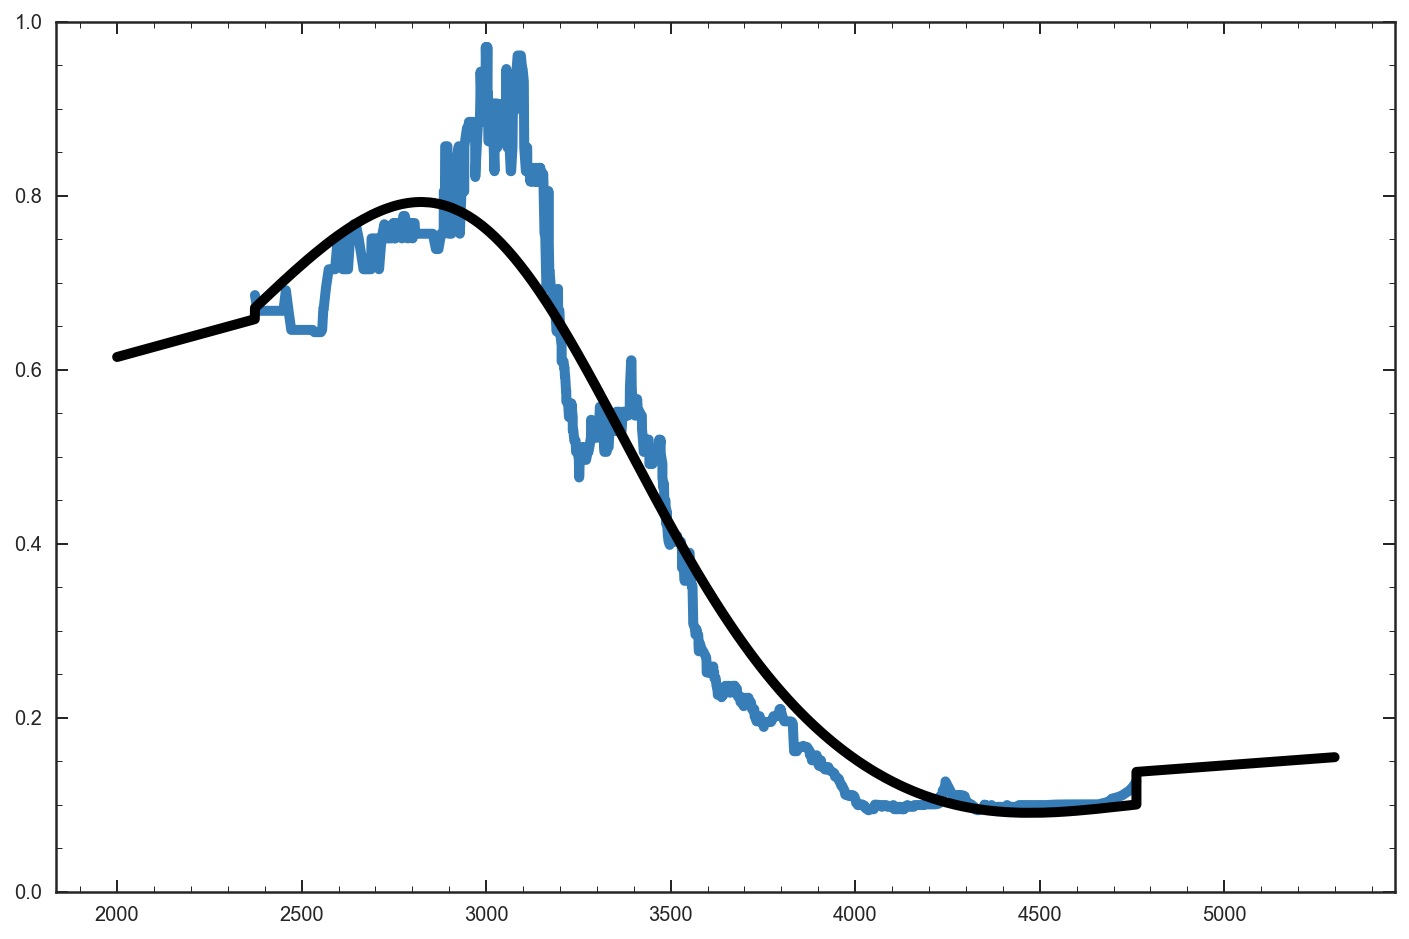

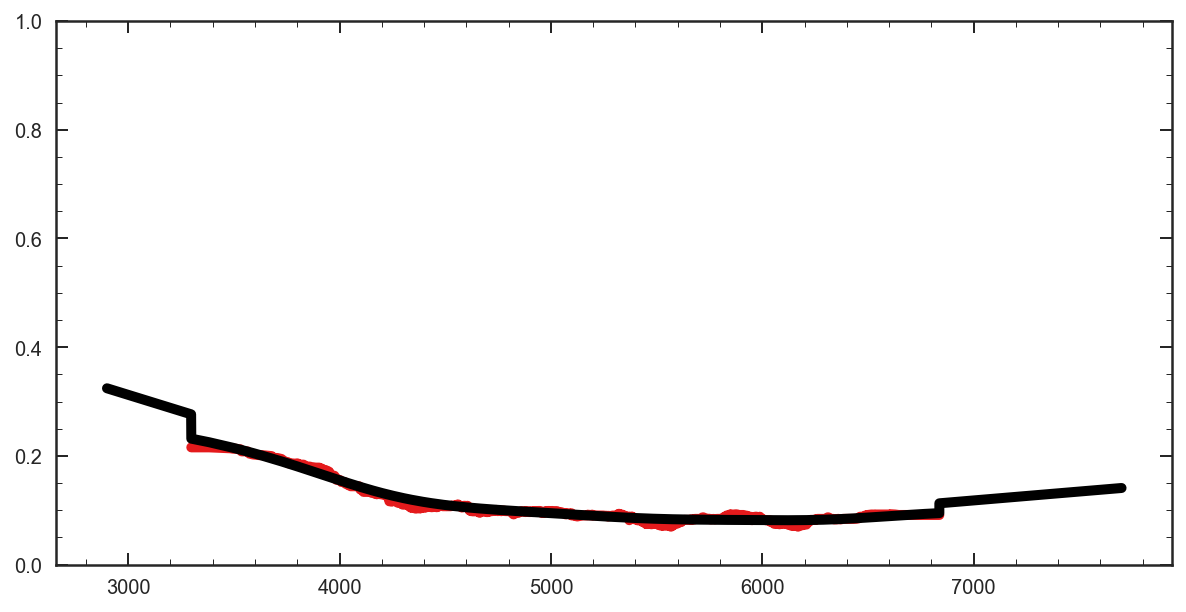

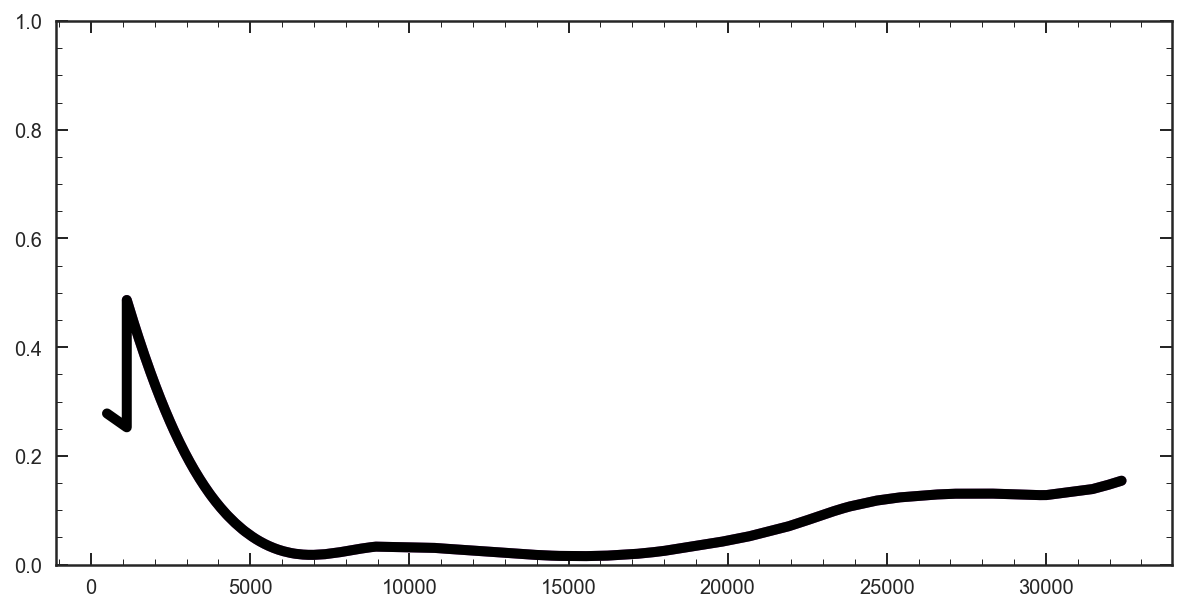

In [150]:
plt.figure(figsize=[12,8])
# plt.scatter(np.log10(B_wave_filt), B_tmp_err,facecolor = '#377eb8',edgecolors='k',linewidth=1,s=10)
plt.plot(B_wave_filt,Run_stat(B_wave_filt,B_tmp_err,100),'#377eb8',linewidth = 5)
# plt.plot(B_wave_filt,Smooth(Run_stat(B_wave_filt,B_tmp_err,100),B_wave_filt,300),'#377eb8',linewidth = 5)
plt.plot(ext_Bwv,ext_Bte,'k',linewidth = 5)

plt.ylim(0,1)

plt.figure(figsize=[10,5])
# plt.scatter(np.log10(R_wave_filt), R_tmp_err,facecolor = '#e41a1c',edgecolors='k',linewidth=1,s=10)
# plt.plot(R_wave_filt,Smooth(R_tmp_err,R_wave_filt,500),'#e41a1c',linewidth = 5)
plt.plot(R_wave_filt,Run_stat(R_wave_filt,R_tmp_err,150),'#e41a1c',linewidth = 5)
# plt.plot(np.log10(R_wave_filt),Smooth(Run_stat(R_wave_filt,R_tmp_err,150),R_wave_filt,300),'#e41a1c',linewidth = 5)
plt.plot(ext_Rwv,ext_Rte,'k',linewidth = 5)

plt.ylim(0,1)

plt.figure(figsize=[10,5])
# plt.scatter(np.log10(P_wave_filt), P_tmp_err,facecolor = '#984ea3',edgecolors='k',linewidth=1,s=10)
# # plt.plot(P_wave_filt,Smooth(P_tmp_err,P_wave_filt,500),'#984ea3',linewidth = 5)
# plt.plot(P_wave_filt,Run_stat(P_wave_filt,P_tmp_err,50),'#984ea3',linewidth = 5)
plt.plot(P_wave_filt,Smooth(Run_stat(P_wave_filt,P_tmp_err,10),P_wave_filt,2000),'#984ea3',linewidth = 5)
plt.plot(ext_Pwv,ext_Pte,'k',linewidth = 5)

plt.ylim(0,1)
# plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])


In [10]:
BWV, BTEF = np.load('../templates/template_error_g102.npy')
RWV, RTEF = np.load('../templates/template_error_g141.npy')         
PWV, PTEF = np.load('../templates/template_error_phot.npy')

In [11]:
IDW =np.array(wv).argsort()

wave = np.array(wv)[IDW]
tmp_err = np.sqrt(np.array(res)**2 - np.array(nerr)**2)[IDW]

wave_filt = wave[tmp_err**2 > 0]
tmp_err = tmp_err[tmp_err**2 > 0]

# wave_filt = wave_filt[tmp_err < 100]
# tmp_err = tmp_err[tmp_err < 100]

wave_filt = wave_filt[tmp_err < 15]
tmp_err = tmp_err[tmp_err < 15]

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [12]:
def Run_bin_stat(wv,tmp,bin_size):
    wv_med = [] ; wv_mean = [] ; binned_data = []

    low_lim = min(wv)
    while low_lim <= max(wv):
        IDX = [U for U in range(len(wv)) if low_lim <= wv[U] < low_lim + bin_size]
        wv_med.append(np.median(wv[IDX]))
        wv_mean.append(np.median(low_lim + bin_size / 2))
        binned_data.append(np.median(tmp[IDX]))
        low_lim += bin_size
    return np.array(wv_med), np.array(wv_mean), np.array(binned_data)


In [13]:
guess_wv,guess_tmp = np.loadtxt('../data/template_geuess.txt').T
IDS = np.argsort(guess_wv)

guess_wv = guess_wv[IDS]
guess_tmp = guess_tmp[IDS]
guess_wv = 10**guess_wv

In [14]:
guess_wv = np.append(np.append(10**3,guess_wv),10**4.6)
guess_tmp = np.append(np.append(0.35,guess_tmp),0.2)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


([<matplotlib.axis.XTick at 0x1a6f714550>,
 <a list of 6 Text xticklabel objects>)

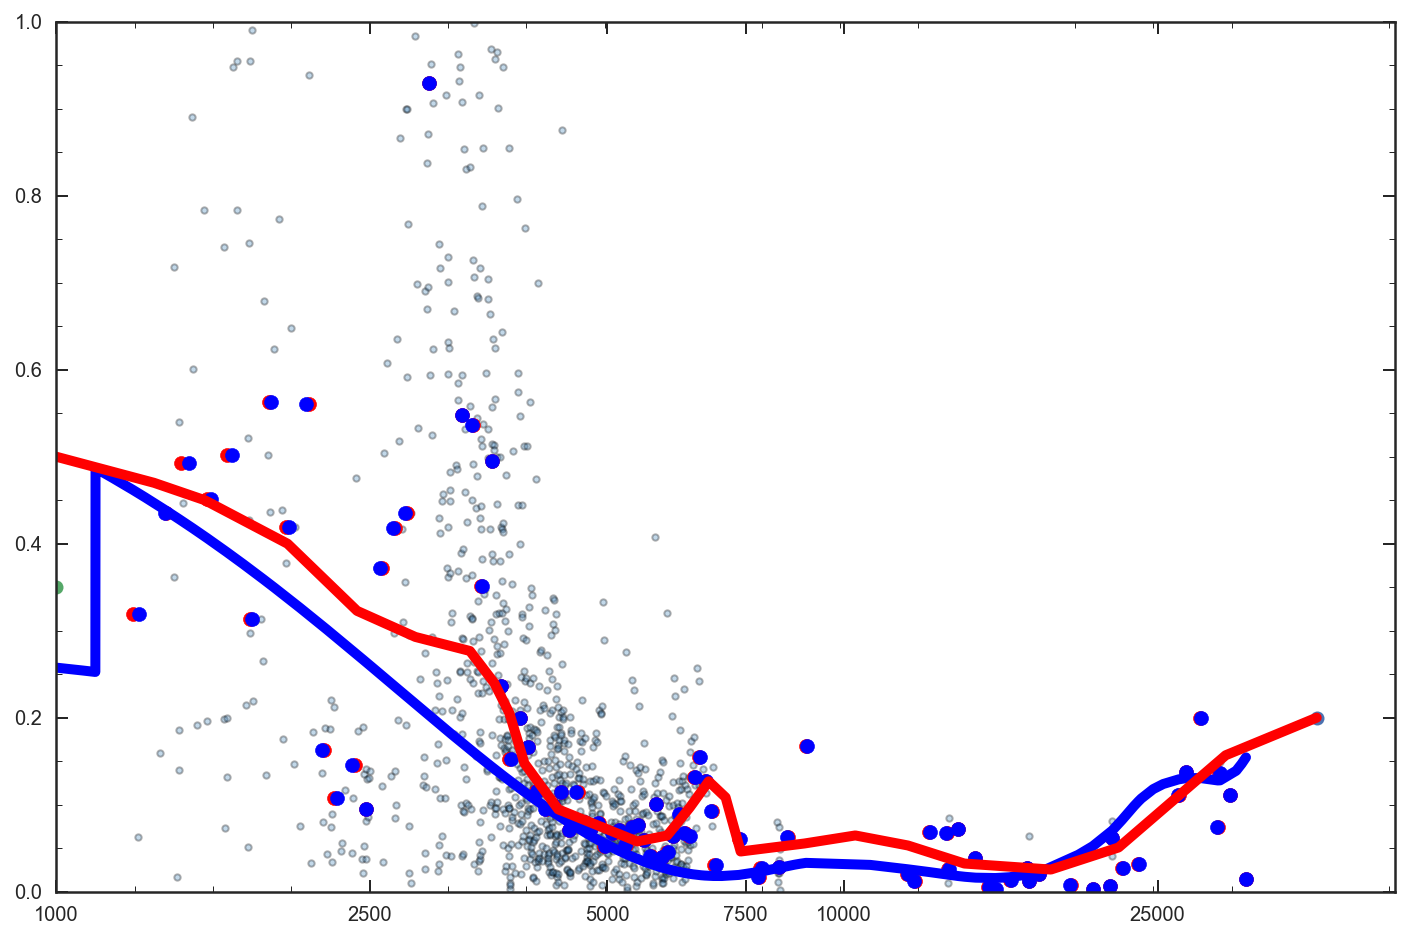

In [22]:
wv_med,wv_mean,binned_data = Run_bin_stat(wave_filt, tmp_err,100)

wv_med = wv_med[binned_data**2 > 0]
wv_mean = wv_mean[binned_data**2 > 0]
binned_data = binned_data[binned_data**2 > 0]

plt.figure(figsize=[12,8])
plt.scatter(np.log10(wave_filt), tmp_err,facecolor = '#377eb8',edgecolors='k',linewidth=1,s=10,alpha=0.3)
# plt.plot(np.log10(wv_med),Smooth(binned_data,np.log10(wv_med),.1),'r',linewidth = 5)
# plt.plot(np.log10(wv_mean),Smooth(binned_data,np.log10(wv_mean),2),'b',linewidth = 5)
plt.plot(4.6,0.2,'o')
plt.plot(3,0.35,'o')
plt.plot(np.log10(PWV),PTEF,'b',linewidth = 5)
plt.plot(np.log10(guess_wv),guess_tmp,'r',linewidth = 5)

plt.scatter(np.log10(wv_med),binned_data, color='r')
plt.scatter(np.log10(wv_mean),binned_data, color='b')
# plt.axvline(np.log10(6564))
plt.ylim(0,1)
plt.xlim(3,4.7)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
# plt.savefig('../plots/template_error.png')

In [18]:
guess_tmp[0] = 0.5 ;guess_tmp[1] = 0.47 ;guess_tmp[2] = 0.45 ;guess_tmp[3] = 0.4  

In [20]:
np.save('../templates/template_error_test.npy',[guess_wv,guess_tmp])

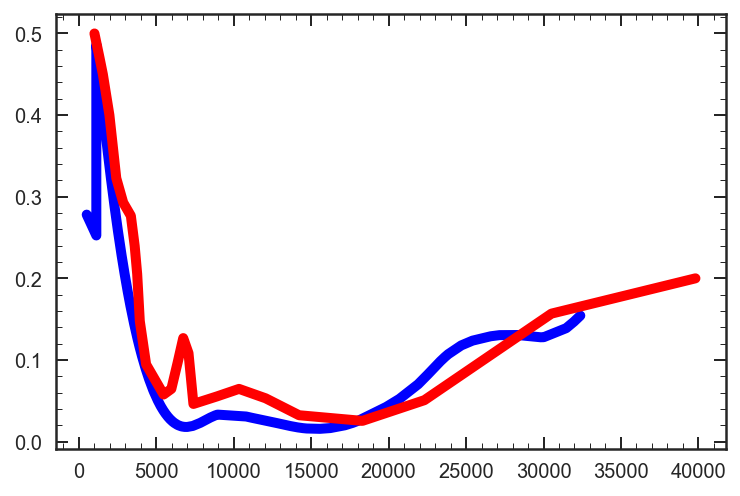

In [23]:
plt.plot(PWV,PTEF,'b',linewidth = 5)
plt.plot(guess_wv,guess_tmp,'r',linewidth = 5)

In [7]:
WV,TEF = np.load('../templates/template_error_test.npy')
ewv, tmp = np.loadtxt('../templates/TEMPLATE_ERROR.eazy_v1.0').T

In [25]:
iWV = np.logspace(np.log10(WV[0]), np.log10(WV[-1]),1000)
iTEF = interp1d(WV,TEF)(iWV)
iEZ = interp1d(ewv,tmp)(iWV)

In [28]:
uTMP = []

for i in range(len(iWV)):
    pairs = [Smooth(iTEF, np.log10(iWV),1E-2)[i], iEZ[i]]
    uTMP.append(max(pairs))

In [31]:
np.save('../templates/template_error_updt.npy', [iWV, uTMP])

(2.9, 5)

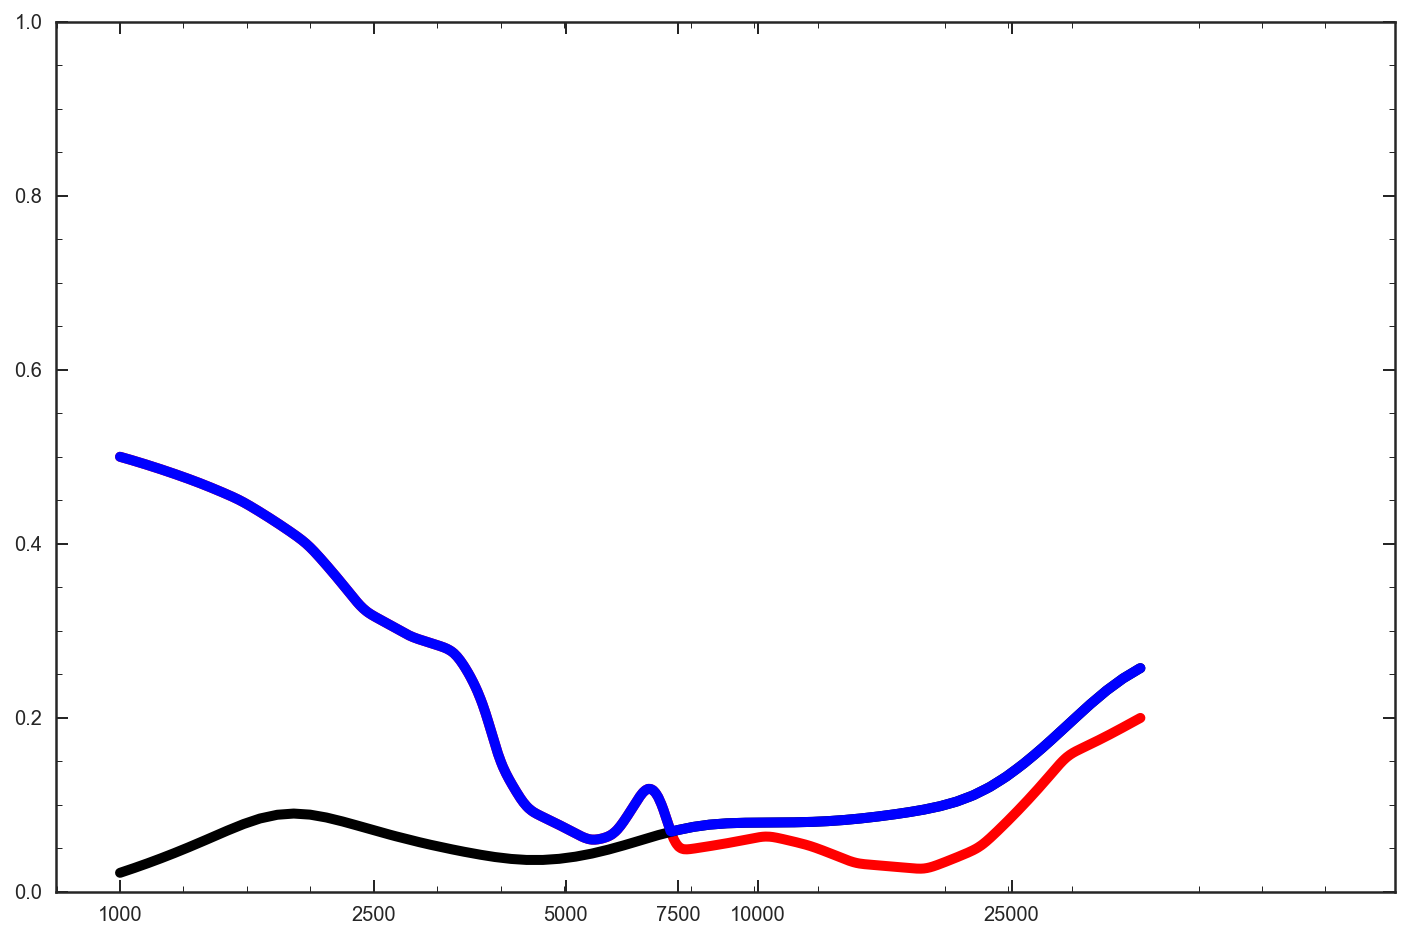

In [30]:
plt.figure(figsize=[12,8])
# plt.plot(np.log10(WV), TEF, '#984ea3',linewidth = 5)
plt.plot(np.log10(iWV), Smooth(iTEF, np.log10(iWV),1E-2), 'r',linewidth = 5)
# plt.plot(np.log10(ewv), tmp, 'k',linewidth = 5)
plt.plot(np.log10(iWV), iEZ, 'k',linewidth = 5)
plt.plot(np.log10(iWV), uTMP, 'b',linewidth = 5)

plt.ylim(0,1)
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
plt.xlim(2.9,5)

In [151]:
# np.save('../templates/template_error_g102',[B_wave_filt,Smooth(Run_stat(B_wave_filt,B_tmp_err,100),B_wave_filt,300)])
# np.save('../templates/template_error_g141',[R_wave_filt,Smooth(Run_stat(R_wave_filt,R_tmp_err,150),R_wave_filt,300)])
# np.save('../templates/template_error_phot',[P_wave_filt,Smooth(Run_stat(P_wave_filt,P_tmp_err,10),P_wave_filt,2000)])

np.save('../templates/template_error_g102',[ext_Bwv,ext_Bte])
np.save('../templates/template_error_g141',[ext_Rwv,ext_Rte])
np.save('../templates/template_error_phot',[ext_Pwv,ext_Pte])

In [24]:
from C_full_fit import Gen_spec2

In [28]:
idx = 22

sp1 = Gen_spec2(galDB.field[idx], galDB.ids[idx], galDB.z_grism[idx], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0],g102_lims=[8500, 11300])  

sp2 = Gen_spec2(galDB.field[idx], galDB.ids[idx], galDB.z_grism[idx], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[idx]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[idx]))[0],g102_lims=[8500, 11300], tmp_err = True, phot_errterm=0.03)  

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)


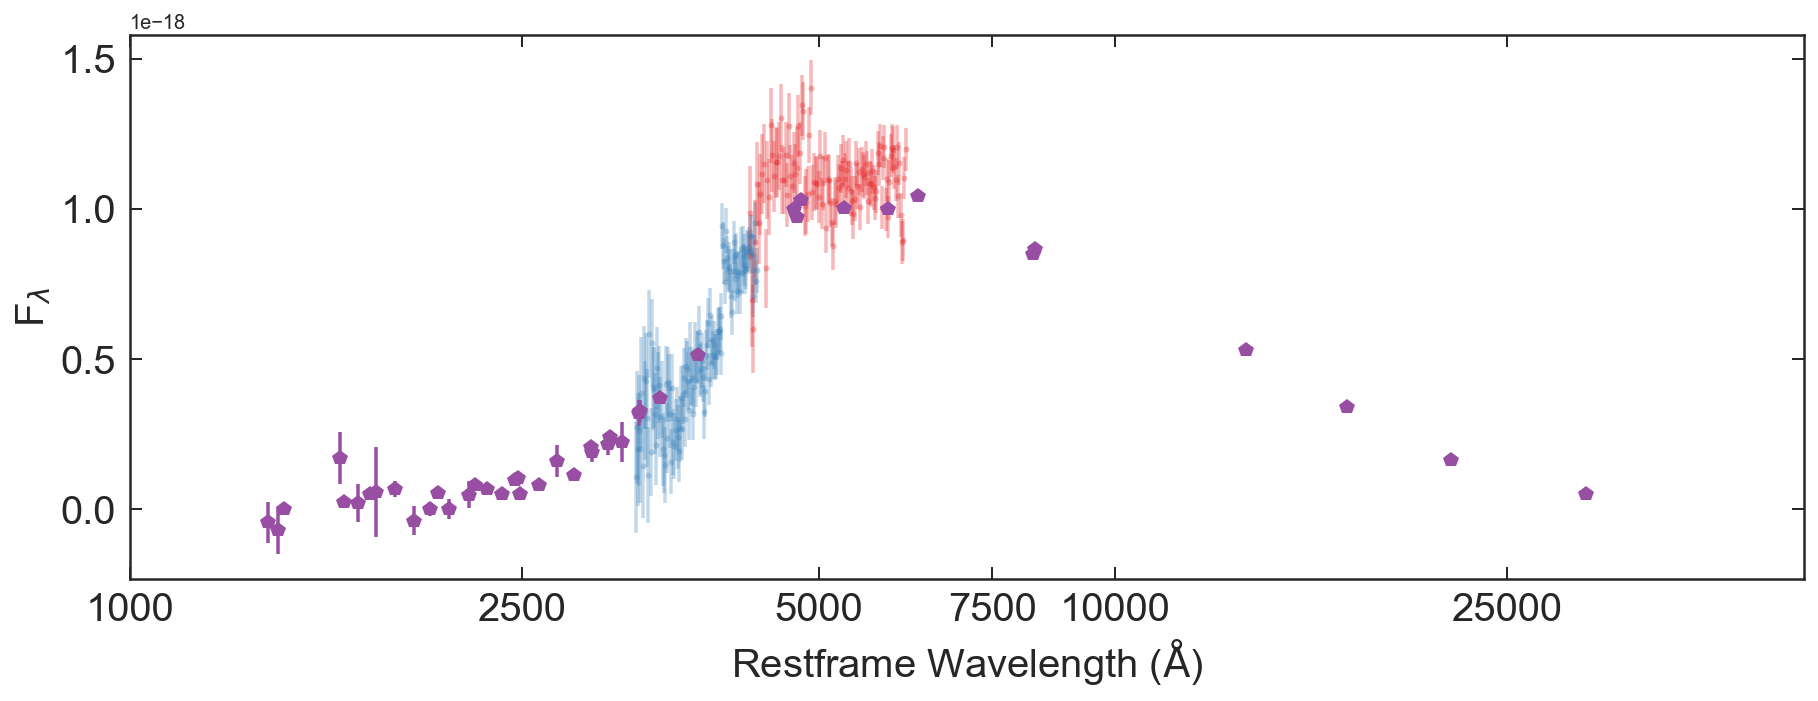

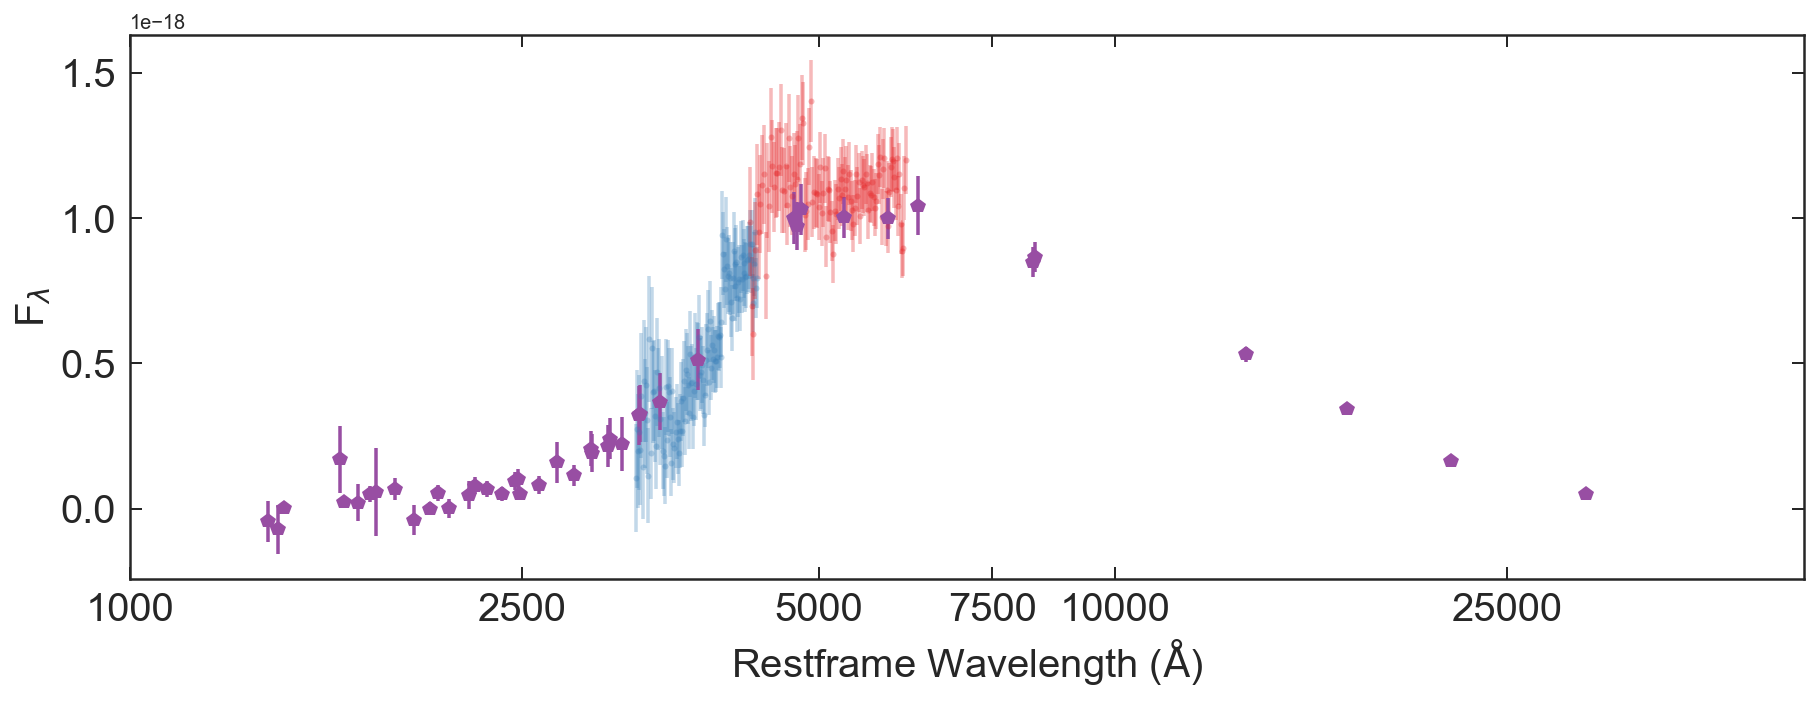

In [30]:
plt.figure(figsize=[15,5])
plt.errorbar(np.log10(sp1.Bwv_rf),sp1.Bflx,sp1.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.errorbar(np.log10(sp1.Rwv_rf),sp1.Rflx,sp1.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)

plt.errorbar(np.log10(sp1.Pwv_rf),sp1.Pflx,sp1.Perr,
                             linestyle='None', marker='p', markersize=8, color='#984ea3')

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
plt.minorticks_off()
plt.xlim(3,np.log10(50000))
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)


plt.figure(figsize=[15,5])
plt.errorbar(np.log10(sp2.Bwv_rf),sp2.Bflx,sp2.Berr,
                linestyle='None', marker='o', markersize=3, color='#377eb8', alpha=.3)
plt.errorbar(np.log10(sp2.Rwv_rf),sp2.Rflx,sp2.Rerr,
            linestyle='None', marker='o', markersize=3, color='#e41a1c', alpha=.3)

plt.errorbar(np.log10(sp2.Pwv_rf),sp2.Pflx,sp2.Perr,
                             linestyle='None', marker='p', markersize=8, color='#984ea3')

plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
plt.minorticks_off()
plt.xlim(3,np.log10(50000))
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)

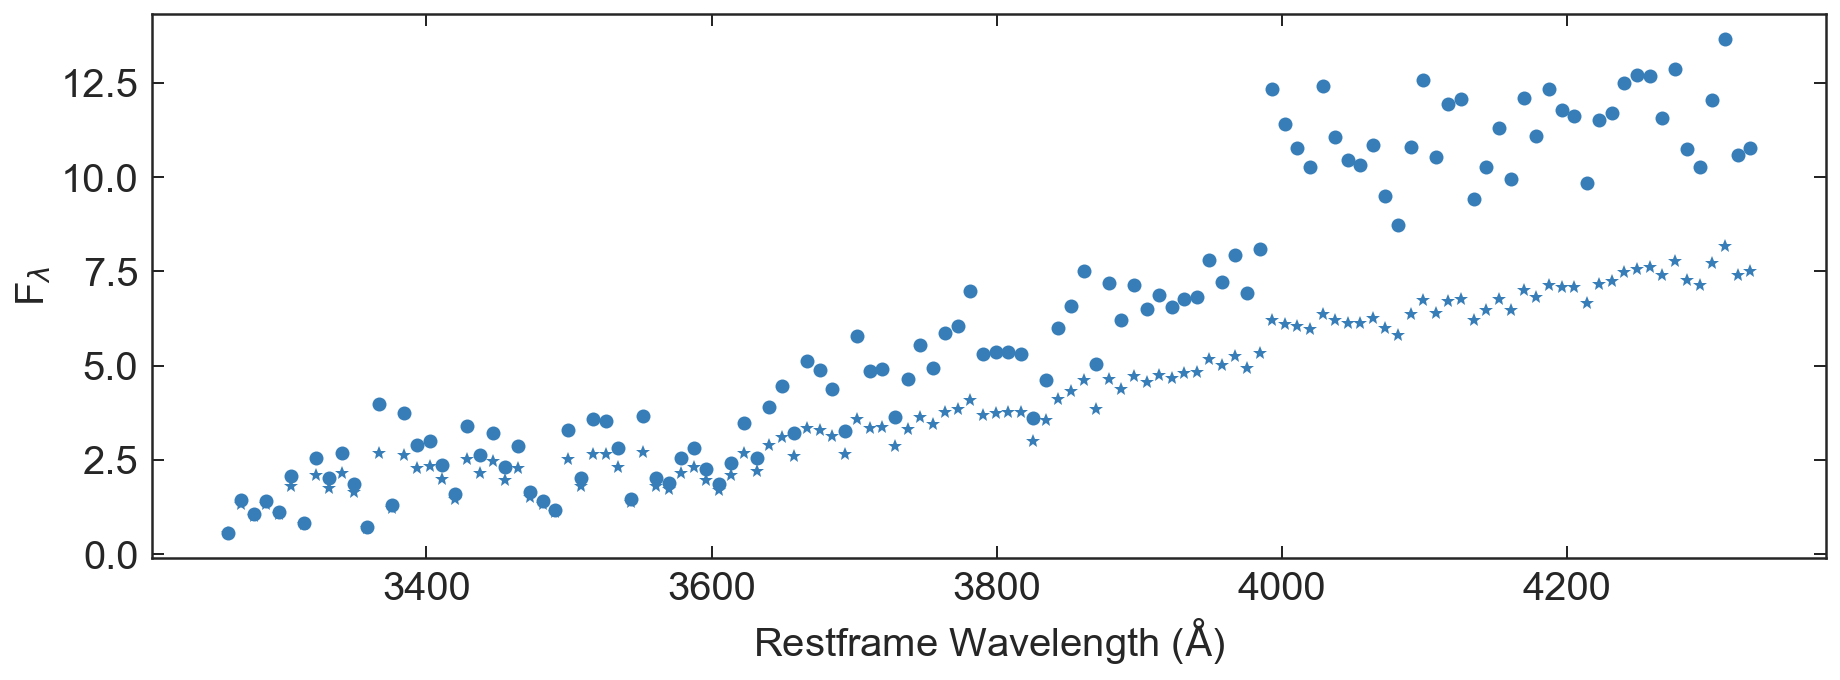

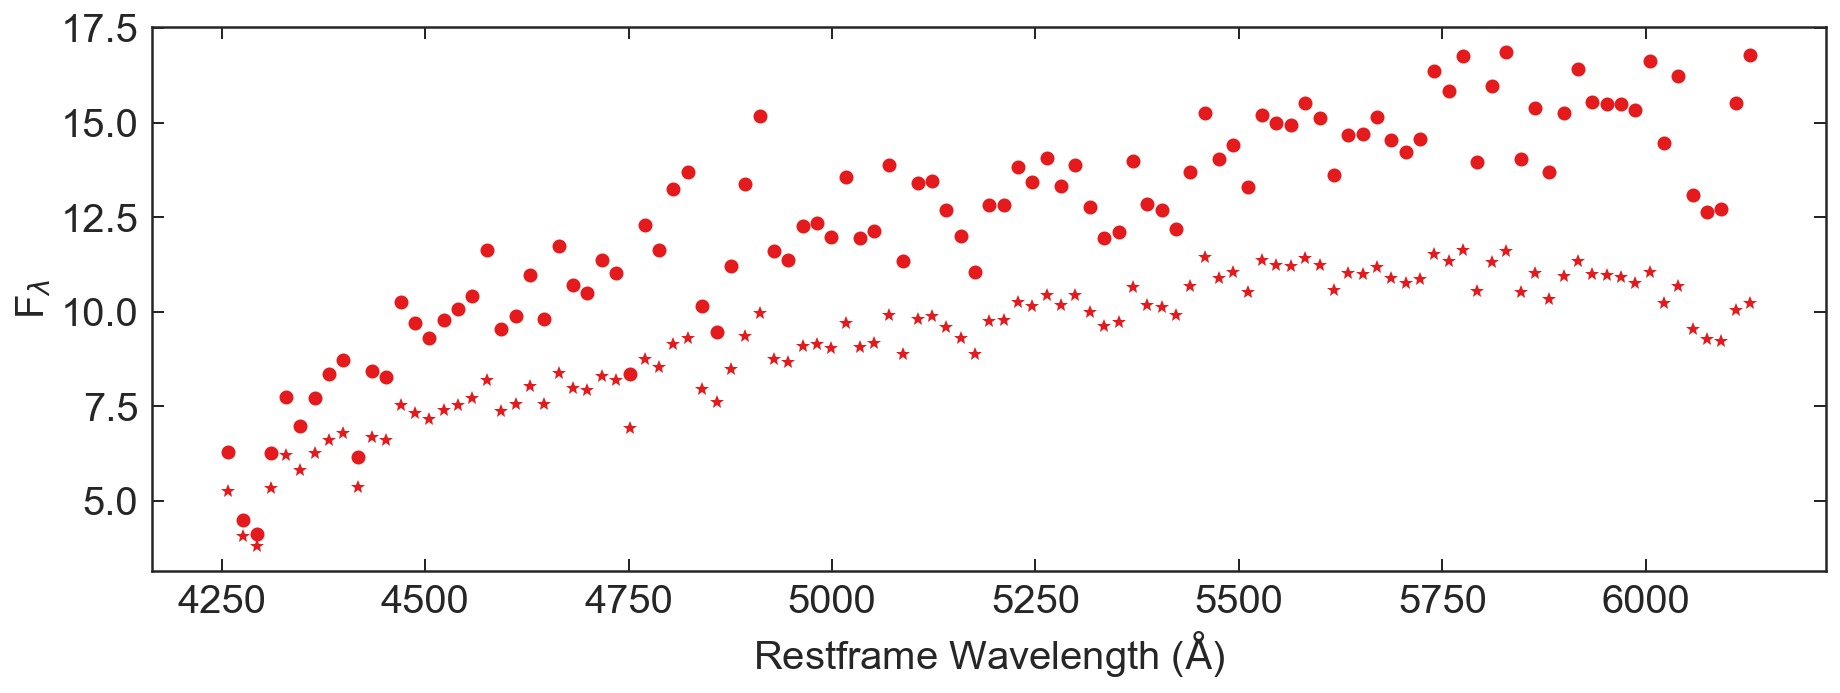

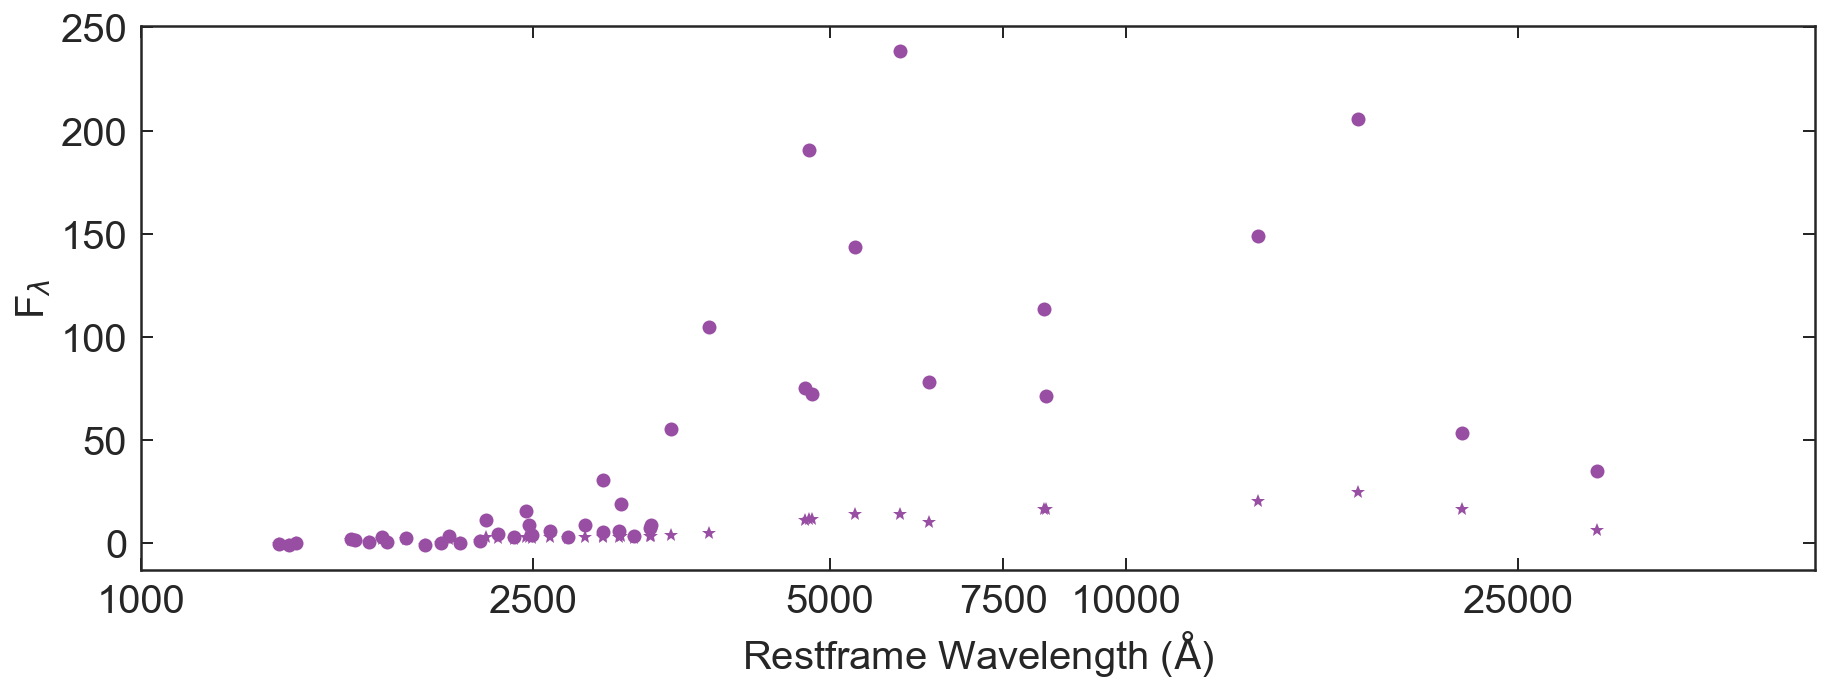

In [31]:
plt.figure(figsize=[15,5])
plt.plot(sp1.Bwv_rf,sp1.Bflx/sp1.Berr, 'o', color='#377eb8')
plt.plot(sp2.Bwv_rf,sp2.Bflx/sp2.Berr, '*', color='#377eb8')
plt.minorticks_off()
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.figure(figsize=[15,5])
plt.plot(sp1.Rwv_rf,sp1.Rflx/sp1.Rerr, 'o', color='#e41a1c')
plt.plot(sp2.Rwv_rf,sp2.Rflx/sp2.Rerr, '*', color='#e41a1c')
plt.minorticks_off()
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)


plt.figure(figsize=[15,5])
plt.plot(np.log10(sp1.Pwv_rf),sp1.Pflx/sp1.Perr, 'o', color='#984ea3')
plt.plot(np.log10(sp2.Pwv_rf),sp2.Pflx/sp2.Perr, '*', color='#984ea3')
plt.xticks(np.log10([1000,2500,5000,7500,10000,25000]),[1000,2500,5000,7500,10000,25000])
plt.minorticks_off()
plt.xlim(3,np.log10(50000))
plt.ylabel('F$_\lambda$',size=20)
plt.xlabel('Restframe Wavelength ($\\rm \AA$)',size=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [32]:
for i in galDB.index:
#     try:
    sp2 = Gen_spec2(galDB.field[i], galDB.ids[i], galDB.z_grism[i], glob('../beams/*{0}*.g102.A.fits'.format(galDB.ids[i]))[0],
              glob('../beams/*{0}*.g141.A.fits'.format(galDB.ids[i]))[0],g102_lims=[8500, 11300], tmp_err = True) 
        
#     except:
#         print(galDB.ids[i],galDB.z_grism[i])

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/m